# Introduction to DESI Data Release 1 

*Ragadeepika Pucha (U.Arizona), Anthony Kremin (Berkeley Lab), Stéphanie Juneau (NOIRLab), Jaime E. Forero-Romero (Uniandes), Farnik Nikakhtar (Yale), Bernardita Ried Guachalla (Stanford) and DESI Data Team*

# Table of Contents

* [Overview](#overview)
* [Imports](#import)
* [Accessing the data](#data_access)
    * [Summary Files](#sumfiles)
    * [Redshift Catalogs](#zcatalog)
    * [Summary Redshift Catalogs](#summary_zcatalog)
    * [Healpix/ Directory](#hpx)
* [Accessing and Plotting Spectra of a Single Object](#spectra_access)
    * [Working with Coadded Spectra using desispec.io.read_spectra](#spectra)
* [References](#ref)

<a class="anchor" id="overview"></a>
# Overview

In this notebook, we will explore the DESI data file structure in the data release 1 (DR1). Information about the release can be found [here](https://data.desi.lbl.gov/doc/releases/). <br/> 
The notebook shows how to access the different files in the data release, to access all the available spectra, along with the redshift information, for a given object, and to finally plot the "best" spectrum. 

A list of technical papers describing the science, targeting and the survey design for the DESI experiment can be found [here](https://data.desi.lbl.gov/doc/papers/).

All links in this tutorial are public unless stated that they are **exclusive to DESI collaborators**.

### Bug Reporting
If you identify any errors or have requests for additional functionality please create a new issue at https://github.com/desihub/tutorials/issues or submit a question on the [DESI User Forum](https://help.desi.lbl.gov).

### Getting Started

#### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc (**link exclusive to DESI collaborators**)

Then do the one-time jupyter configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC (**link exclusive to DESI collaborators**)

From a NERSC command line, checkout a copy of the tutorial code, *e.g.* from perlmutter.
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter.nersc.gov, login, navigate to where you checked out this package (*e.g.* `$HOME/desi/tutorials/getting_started`), and double-click on `intro_to_DESI_files.ipynb`.


#### Setting up the DESI environment (kernel)

For those referring to this in 2023 or beyond: this tutorial has been tested using the "DESI 23.1" kernel installed at NERSC. If you don't see that installed, you will need to open a terminal either in jupyterhub or via an actual terminal logged in to NERSC and do the following:

```console
source /global/common/software/desi/desi_environment.sh 23.1
${DESIMODULES}/install_jupyter_kernel.sh 23.1

```
You'll then need to restart your jupyterhub instance to see the kernel. After following the step above and restarting: you can go to the Kernel menu, select "Change Kernel", then select 'DESI 23.1' from the dropdown menu.

<a class="anchor" id="import"></a>
# Imports

In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('../mpl/desi.mplstyle')

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask, scnd_mask

<a class="anchor" id="data_access"></a>
# Accessing the data

The DESI Data Release 1 (DR1) includes spectra for ~17 million unique targets from Main survey observations taken from May 2021 through June 2022.

For the DR1 data, the spectra are divided by the `SURVEY` (main/special) they were observed in. The observing conditions (dark or bright), called as `PROGRAM` in the DESI terminology, is used to categorize the spectra further. 

For the Early Data Release (EDR) data, check the directory in the `~/tutorials/getting_started/EDR`


In [3]:
# Release directory path

specprod = 'guadalupe'    # Internal name for the DR1
specprod_dir = '/global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe/'
print(specprod_dir)

/global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe/


In [4]:
# List everything in this directory
os.listdir(specprod_dir)

['healpix',
 'inventory-guadalupe.txt',
 'tiles',
 'exposures-guadalupe.csv',
 'tiles-guadalupe.csv',
 'run',
 'calibnight',
 'redux_guadalupe.sha256sum',
 'exposures',
 'tiles-guadalupe.fits',
 'processing_tables',
 'preproc',
 'exposure_tables',
 'exposures-guadalupe.fits',
 'zcatalog']

### Important files to Note:

1. tiles-guadalupe.fits (or .csv) -- This contains information about the observed tiles.
2. exposures-guadalupe.fits (or .csv) -- This consists of information about individual exposures of the targets.
3. zcatalog/ Directory -- This directory contains all of the redshift catalogs.
4. tiles/ Directory -- This directory holds all of the per-tile coadds and redshifts, in various flavors. (12/13: what's flavors??)
5. healpix/ Directory -- This directory holds all of the coadds and redshifts based on sky location (healpix).

<a class="anchor" id="sumfiles"></a>
## Summary Files

Let's first take a look at the tiles and exposure summary files.

### tiles-guadalupe.fits
This file tells you what tiles were observed, what `SURVEY` and `PROGRAM` they were observed for, some observing conditions, and three estimates of the "effective time" (in seconds) that each tile acquired. The time estimate used for survey operations decisions is `EFFTIME_SPEC`. The datamodel for this table is described [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html).

In [5]:
tiles_table = Table.read(f'{specprod_dir}/tiles-{specprod}.fits',)
print(f"Tiles table columns: {tiles_table.colnames}")

Tiles table columns: ['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


In [6]:
tiles_table[0:5]

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32
21184,main,bright,bright,mainbright,2,1801.6,203.941,32.308,180.9,250.8,276.0,180.0,obsend,242.1,225.4,250.8,153.2,bright,0.85,20210514
21202,main,bright,bright,mainbright,1,547.0,218.264,33.645,181.5,204.7,225.5,180.0,obsend,201.7,190.4,204.7,151.3,bright,0.85,20210514
21196,main,bright,bright,mainbright,1,566.2,214.298,34.258,181.3,203.8,225.7,180.0,obsend,200.4,189.6,203.8,149.0,bright,0.85,20210514
1404,main,dark,dark,maindark,2,1987.0,248.17,3.391,1001.1,1111.3,1063.8,1000.0,obsend,1133.2,1111.3,1081.3,1006.9,dark,0.85,20210514
20240,main,bright,bright,mainbright,1,585.4,232.699,33.213,181.8,205.7,221.6,180.0,obsend,204.6,197.6,205.7,130.2,bright,0.85,20210514


Let's use this to find the number of tiles in each SURVEY and each PROGRAM.

In [7]:
np.unique(tiles_table["SURVEY"])

main
special


In [8]:
for survey in ['main', 'special']:
    print(f'{survey}: Ntiles = {np.sum(tiles_table["SURVEY"]==survey)}')

main: Ntiles = 648
special: Ntiles = 5


In [9]:
np.unique(tiles_table["PROGRAM"])

bright
dark


In [10]:
for program in ['bright', 'dark']:
    print(f'{program}: Ntiles = {np.sum(tiles_table["PROGRAM"]==program)}')

bright: Ntiles = 347
dark: Ntiles = 306


### exposures-guadalupe.fits
This file is primarily used for daily operations, but can be handy for looking at individual exposures and the amount of "EFFECTIVE TIME" that exposure acquired. <br/>
The datamodel for this file is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html).

In [11]:
exp_table = Table.read(f'{specprod_dir}/exposures-{specprod}.fits', hdu='EXPOSURES')
print(f"Tiles table columns: {exp_table.colnames}")

Tiles table columns: ['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'EXPTIME', 'EFFTIME_SPEC', 'GOALTIME', 'GOALTYPE', 'MINTFRAC', 'AIRMASS', 'EBV', 'SEEING_ETC', 'EFFTIME_ETC', 'TSNR2_ELG', 'TSNR2_QSO', 'TSNR2_LRG', 'TSNR2_LYA', 'TSNR2_BGS', 'TSNR2_GPBDARK', 'TSNR2_GPBBRIGHT', 'TSNR2_GPBBACKUP', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GPB_EFFTIME_DARK', 'GPB_EFFTIME_BRIGHT', 'GPB_EFFTIME_BACKUP', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'FIBER_FRACFLUX_GFA', 'FIBER_FRACFLUX_ELG_GFA', 'FIBER_FRACFLUX_BGS_GFA', 'FIBERFAC_GFA', 'FIBERFAC_ELG_GFA', 'FIBERFAC_BGS_GFA', 'AIRMASS_GFA', 'SKY_MAG_AB_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'EFFTIME_GFA', 'EFFTIME_DARK_GFA', 'EFFTIME_BRIGHT_GFA', 'EFFTIME_BACKUP_GFA']


In [12]:
exp_table[-5:]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA
int32,int32,int32,float64,float64,float64,bytes7,bytes6,bytes6,bytes13,float64,float64,float64,bytes6,float64,float32,float32,float64,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210709,98063,80978,207.29,52.877,59405.18749165,special,bright,bright,specialbright,1452.697509765625,197.93568420410156,180.0,bright,0.85,1.202465,0.009743289,1.863860011100769,151.2682647705078,18.956692,4.101639,15.124872,12.014702300610953,1413.8263,2194.3481,431.67792,2670.969,186.45721,163.02756,197.93568,137.44528712745898,189.95865,226.73135,195.7535,0.6593625244628543,1.8006506942972114,0.293470905821148,0.2354617956792806,0.11560360294509728,0.3047878942967975,0.3364294719748532,0.35885390319459404,1.227681448866262,21.1337467259341,22.135956405240883,21.185256780372157,19.509745863996592,197.15048370539202,176.74068194305812,197.15048370539202,136.52320338986775
20210709,98064,80978,207.29,52.877,59405.20512921,special,bright,bright,specialbright,368.65325927734375,41.05720901489258,180.0,bright,0.85,1.257773,0.009743289,1.863860011100769,30.13050651550293,3.9019833,0.81733656,3.0641327,1.549292367201997,293.26578,420.2972,84.5462,545.81854,37.77418,33.557056,41.05721,17.723529799288563,36.383965,44.40643,40.00267,0.7280815651045056,1.8190103793152292,0.28946239636383586,0.23343622282069942,0.11482897667832394,0.3335415933738518,0.3682952365301943,0.39394000796692175,1.2658936535974437,21.064701180660066,22.147039556439665,21.162949643973484,19.4262454384383,41.99840782806806,35.674815216228865,41.99840782806806,32.006462833771856
20210709,98065,20762,250.42,35.752,59405.21465953,main,bright,bright,mainbright,645.6358642578125,251.03213500976562,180.0,bright,0.85,1.003564,0.020572834,1.3286219835281372,183.17111206054688,25.288977,5.890546,19.75897,13.614389088796452,1793.0867,2877.6245,537.81537,3284.0215,243.58571,217.48521,251.03214,155.74531690888588,249.10799,282.4782,240.6837,0.9113439779102812,1.5250489248330703,0.36812758718321514,0.28514889555021083,0.13682403265334298,0.5577076948063677,0.5941102921140221,0.6193902059214809,1.0047695098331595,21.42711967537739,22.442421379070574,21.503394066649815,19.672368905775144,260.6618297248638,247.7453101920873,260.6618297248638,199.82414818613137
20210709,98066,20761,250.378,39.09,59405.22378742,main,bright,bright,mainbright,472.75506591796875,208.796142578125,180.0,bright,0.85,1.012705,0.016557783,1.5384420156478882,183.99053955078125,21.152025,5.0860453,16.38142,11.205386397033,1491.401,2371.5518,441.53662,2818.5903,201.94775,181.90742,208.79614,128.1869090202932,205.29866,231.90945,206.57257,0.9402062232345167,1.3956305505009627,0.41805845253277,0.31782840808089563,0.15066017162271467,0.6387801993601208,0.6678438885120485,0.6879237531177177,1.0142118648402425,21.41111260750814,22.422249159528036,21.5063114038092,19.607221805200382,216.0028534974469,205.3693443273242,216.0028534974469,183.49923947134252
20210709,98067,20924,254.117,37.273,59405.23093739,main,bright,bright,mainbright,399.0263366699219,200.94448852539062,180.0,bright,0.85,1.00779,0.016173482,1.5751819610595703,186.51197814941406,20.501034,5.027661,15.73329,10.930441

Let's use this to find the number of exposures in each `SURVEY` and each `PROGRAM`.

In [13]:
np.unique(exp_table["SURVEY"])

main
special


In [14]:
for survey in ['main', 'special']:
    print(f'{survey}: Nexps={np.sum(exp_table["SURVEY"]==survey)}')

main: Nexps=753
special: Nexps=33


In [15]:
np.unique(exp_table["PROGRAM"])

bright
dark


In [16]:
for program in ['bright', 'dark']:
    print(f'{program}: Nexps={np.sum(exp_table["PROGRAM"]==program)}')

bright: Nexps=406
dark: Nexps=380


<a class="anchor" id="zcatalog"></a>

## Redshift Catalogs

The redshift catalogs that are in the `zcatalog/` directory are divided into `zpix` and `ztile` files. The `zpix` files have the format: `zpix-{survey}-{program}.fits`, while the `ztile` have the format: `ztile-{survey}-{program}-{group}.fits`. The datamodel for the different files within this folder can be found [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html). Each of these files contain redshift and targeting information of the sources based on how their spectra are coadded. 

* **survey**: SURVEY that the target was observed in. This can be main or special.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright or backup. In case of cmx and sv1, there is 'other' as well.
* **group**: This denotes what type of coadd. It can be perexp, pernight, or cumulative.

For example, `zpix-sv1-dark.fits` contains information about the targets that were observed in SV1 for the _dark_ program. Since it is healpix based, the resulting spectra for a particular target is the coadded spectra across all tiles that were observed within the given `SURVEY` and `PROGRAM`. This will provide the highest S/N version of each target.

Note that some of the targets were observed in multiple surveys and/or programs. In such cases, one may want to select the _PRIMARY_ spectrum of a given object. This information is available in the redshift summary catalogs, which will be explained in detail below.

In [17]:
# Listing all the available redshift catalogs

os.listdir(f'{specprod_dir}/zcatalog')

['ztile-special-dark-cumulative.fits',
 'zall-tilecumulative-guadalupe.fits',
 'ztile-main-dark-perexp.fits',
 'ztile-main-bright-perexp.fits',
 'zpix-main-dark.fits',
 'ztile-special-dark-pernight.fits',
 'ztile-main-dark-pernight.fits',
 'ztile-main-dark-cumulative.fits',
 'v1',
 'ztile-main-bright-pernight.fits',
 'ztile-special-bright-cumulative.fits',
 'v0',
 'zpix-special-bright.fits',
 'ztile-main-bright-cumulative.fits',
 'zpix-special-dark.fits',
 'zpix-main-bright.fits',
 'ztile-special-dark-perexp.fits',
 'zall-pix-guadalupe.fits',
 'ztile-special-bright-perexp.fits',
 'ztile-special-bright-pernight.fits']

Now, we will look at the summary redshift catalogs that contain the `PRIMARY` spectra information

<a class="anchor" id="summary_zcatalog"></a>
## Summary Redshift Catalogs

There are two summary redshift catalogs: <br/>
**zall-pix-fuji.fits** <br/> 
This is a stack of all the healpix-based redshift catalogs, including all surveys and programs. The datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html). <br/>
**zall-tilecumulative-fuji.fits** <br/>
This is a stack of all the tile-based cumulative redshift catalogs, including all surveys and programs. The datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html).

For both these summary catalogs, all the columns in the original catalogs ([zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html) and [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)) are included. <br/>
Four new columns are added:

1. SV_NSPEC - Number of SV spectra available of each target.
2. SV_PRIMARY - PRIMARY flag for the sources with SV spectra.
3. ZCAT_NSPEC - Number of spectra available in the entire catalog of each target.
4. ZCAT_PRIMARY - PRIMARY flag for the sources in the entire catalog.

### Tile-based vs healpix-based
The choice of which you use will depend on your specific science case. If you want the hightest S/N spectra then you'll likely want to use healpix based redshifts. If you want a more consistant observing depth among the redshfits in your sample, or you need objects that fit on a single pointing, then tile redshifts may be of more 
interest.

We will focus here on the healpix based redshifts.

### Working with the zall-pix file

In [18]:
zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")

In [19]:
print(zpix_cat.columns)

<TableColumns names=('TARGETID','SURVEY','PROGRAM','HEALPIX','SPGRPVAL','Z','ZERR','ZWARN','CHI2','COEFF','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','DESI_TARGET','BGS_TARGET','MWS_TARGET','SCND_TARGET','PLATE_RA','PLATE_DEC','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','MEAN_FIBER_RA','STD_FIBER_RA','MEAN_FIB

In [20]:
zpix_cat[0:5]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
39633469940171332,main,bright,7511,7511,0.28337673749580955,7.154802868071135e-06,0,7860.9365611076355,695.476901893503 .. 19.893199012252776,7844,GALAXY,--,10,3092.0155391693115,0,179.455490923371,67.76490702620121,0.0,0.0,2015.5,5764607523034234880,1,TGT,0.7621476878510232,575,9011,1796p677,637252,580,SER,0.014673854,5.0360045,8.831774,13.13303,20.747002,17.237303,371.30804,97.35847,30.622875,4.219001,1.2209353,1.885743,3.3070772,4.917692,1.885743,3.3070772,4.917692,0,0.5,1.115134,-0.24193946,0.41083065,0,--,0.0,0.0,0.0,0.0,N,2000,2,5764607523034234880,257,0,131072,179.455490923371,67.76490702620121,1,753.7646,1,1,0.002,0.002,-0.001,0.001,179.45551183401273,0.0,67.76491080770683,0.0,0.7497051,38.026283,0.014840261,7.3928657,10.581994,86.32642,59.77755,0.37184647,0.16947936,2449.3333,5.0196247,471.11646,0.010613538,560.95886,3672.4604,1.529081,7.5550327,4.6414407e-06,24.297,9.034072e-07,0.0,981.9657,7.340865e-06,4.517524,10.635262,2487.3596,29.331467,478.5093,10.5926075,1629.251,3732.238,6.4184513,18.359774,1,True,1,True
39633467620723510,main,bright,7511,7511,0.11748941090338338,3.422120774807325e-05,0,7667.00874569267,504.9044223836267 .. -11.96083329212282,7864,GALAXY,--,10,164.75942448992282,0,179.28792361703015,67.56788859049287,0.0,0.0,2015.5,1152921504606846976,1,TGT,0.5278274073200345,516,9011,1790p675,636699,2870,SER,0.0111059,31.018847,66.35231,113.755264,86.57331,48.98327,60.298508,12.053989,3.4353943,1.7018696,0.6321934,2.1890242,4.682534,8.027798,2.2386591,4.7736363,8.119488,0,1.0946615,3.1682746,-0.101468824,-0.05095779,0,--,0.0,0.0,0.0,0.0,N,2100,2,1152921504606846976,514,0,0,179.28792361703015,67.56788859049287,1,753.7646,1,1,0.001,0.001,0.01,0.01,179.2879364033728,0.0,67.56785189865819,0.0,0.7169982,44.35013,0.018233797,8.674738

In [21]:
print(f"Raw number of zcat entries: {len(zpix_cat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Raw number of zcat entries for spectype '{spectype}': {np.sum(zpix_cat['SPECTYPE']==spectype):,}")

Raw number of zcat entries: 3,212,502
Raw number of zcat entries for spectype 'GALAXY': 2,381,916
Raw number of zcat entries for spectype 'QSO': 278,885
Raw number of zcat entries for spectype 'STAR': 551,701


### Available sources based on Targeting Information

There are five main target types used in DESI:
1. Milky Way Survey (MWS)
2. Bright Galaxy Survey (BGS)
3. Luminous Red Galaxies (LRG)
4. Emission Line Galaxies (ELG)
5. Quasars (QSO).

Information about how the original targets were selected is available separately for [SV1](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation), [SV2](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV2), and [SV3](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV3) (**links exclusive to DESI collaborators**). Based on the tests on SV data, the finalized target selection for the main survey is available [in this paper](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract). <br/>

In [22]:
desi_tgt = zpix_cat['DESI_TARGET']

is_bgs  = (desi_tgt & desi_mask['BGS_ANY'] != 0)
is_lrg  = (desi_tgt & desi_mask['LRG'] != 0)
is_elg  = (desi_tgt & desi_mask['ELG'] != 0)
is_qso  = (desi_tgt & desi_mask['QSO'] != 0)
is_mws  = (desi_tgt & desi_mask['MWS_ANY'] != 0)
is_scnd = (desi_tgt & desi_mask['SCND_ANY'] != 0)

In [23]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

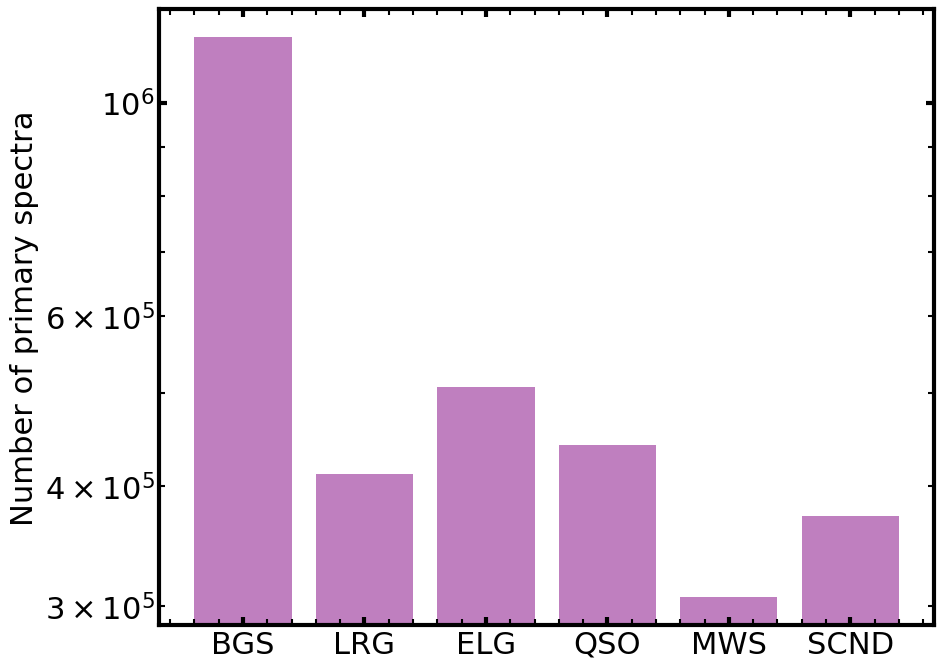

In [24]:
# Let us look at the numbers visually - 

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

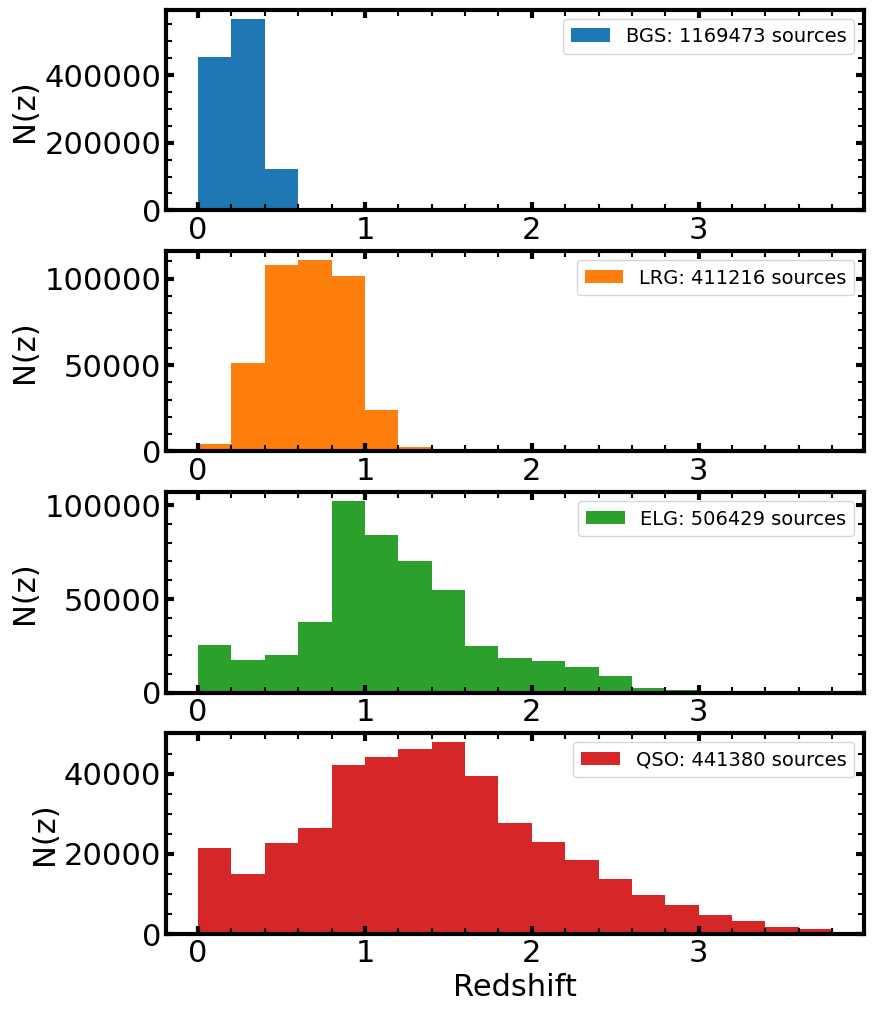

In [25]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zpix_cat['Z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zpix_cat['Z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zpix_cat['Z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zpix_cat['Z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


#### Other masks

`desi_mask` consists of the uppermost level targeting information in DESI. However, there can be sub-classes of targets. For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns in the redshift catalog. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

Now, we will explore the Healpix/ directory and see how to access the required coadded spectra

<a class="anchor" id="hpx"></a>
## Healpix/ Directory

This directory divides the coadded spectra of targets based on the healpix number and the observing conditions (dark/bright).

In [26]:
healpix_dir = f'{specprod_dir}/healpix'

In [27]:
os.listdir(healpix_dir)

['main',
 'special',
 'tilepix.json',
 'redux_guadalupe_healpix.sha256sum',
 'tilepix.fits']

The directories in `healpix` folder are divided based on the `SURVEY` and then by the `PROGRAM` (dark or bright or backup).

In [28]:
# Define survey and program here - 
survey = 'main'
program = 'bright'

In [29]:
os.listdir(f'{healpix_dir}/{survey}')

['bright', 'dark']

In [30]:
sorted(os.listdir(f'{healpix_dir}/{survey}/{program}'))[0:10]

['100', '101', '102', '103', '104', '105', '106', '107', '108', '110']

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting Spectra of a Single Object

Under the healpix/ directory, the different healpix directories are grouped together in healpix subgroups. 

To access a particular coadded spectra, we need the following information:

* **survey**: SURVEY that the target was observed in. This can be sv1, sv2, or sv3.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright or backup. In the case of sv1, we also have "other".
* **healpix**: HEALPIX Number, which depends on the position of the object in the sky.

The coadd filepath can be created using this -
```
{healpix_directory}/{survey}/{program}/{healpix_group}/{healpix}/coadd-{survey}-{program}-{healpix}.fits
```
The healpix group can be derived from the healpix number. 

In [31]:
# Selecting a random object which has multiple spectra in DESI
sel = (zpix_cat['ZCAT_NSPEC'] >= 2)
targets = zpix_cat[sel]['TARGETID']

## Selecting random TARGETID from these targets
ii = 16
targetid = targets[ii]

In [32]:
# Selecting the redshift catalogs rows for the particular targetid
rows = zpix_cat['TARGETID'] == targetid
zcat_sel = zpix_cat[rows]

In [33]:
zcat_sel

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
39627824734144646,main,bright,8194,8194,0.39173109822745655,3.0673960789772844e-05,0,9759.266608446836,0.0010673848115522128 .. 0.0,7914,QSO,--,4,6647.579368442297,0,224.58988470335294,1.378163090440557,-0.2549944,0.4667033,2015.5,1152921504606912513,1,TGT,0.9144913411008377,517,9010,2246p015,339906,2182,SER,0.04677228,7.805174,19.405815,40.540184,132.02184,170.83188,816.89996,164.906,44.39299,1.5251052,0.40296662,4.4164743,10.980574,22.93923,4.4250703,11.029286,23.006535,0,6.0,0.4470902,0.34433308,-0.017582905,1153270771348031360,G2,19.980867,20.158333,18.739634,1.3080442,S,2100,2,1152921504606912513,131074,0,0,224.58988470335294,1.378163090440557,2,1502.9965,2,1,0.002,0.0028284271,0.0025,0.002915476,224.5898928445509,0.028640714,1.3781532419202565,0.020617807,0.776352,39.407635,0.01460542,7.682243,7.2803917,90.11328,62.67115,0.3610164,0.1842224,1975.6283,4.4948115,378.43198,0.005834971,426.325,2891.5244,1.2575481,6.5305805,4.4385356e-06,13.906635,8.602072e-07,0.0,780.54803,6.874902e-06,2.903956,7.256494,2015.0359,18.416052,386.11423,7.2862267,1296.9863,2954.1956,4.5225205,13.971296,2,False,2,False
39627824734144646,main,dark,8194,8194,0.39186269509492716,1.4014261628813523e-05,0,16512.01973736286,0.0011610984195457206 .. 0.0,7923,QSO,--,4,29740.71864876151,0,224.58988470335294,1.378163090440557,-0.2549944,0.4667033,2015.5,1152921504606912513,1,TGT,0.429978888164411,517,9010,2246p015,339906,2182,SER,0.04677228,7.805174,19.405815,40.540184,132.02184,170.83188,816.89996,164.906,44.39299,1.5251052,0.40296662,4.4164743,10.980574,22.93923,4.4250703,11.029286,23.006535,0,6.0,0.4470902,0.34433308,-0.017582905,1153270771348031360,G2,19.980867,20.158333,18.739634,1.3080442,S,3200,2,1152921504606912513,131074,0,0,224.58988470335294,1.378163090440557,2,209

In [34]:
# Defining healpix, survey, and program variables for this target

survey_col = zcat_sel['SURVEY'].astype(str)
program_col = zcat_sel['PROGRAM'].astype(str)
hpx_col = zcat_sel['HEALPIX']

# Selecting the primary spectra - 
is_primary = zcat_sel['ZCAT_PRIMARY']

# Information needed to access the spectra 
survey = survey_col[is_primary][0]
program = program_col[is_primary][0]
hpx = hpx_col[is_primary][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

# Let us explore the target directory
# Note that the target directory is different for the different spectra.
# We first explore the primary spectra and look at the other spectra later.
tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'

In [35]:
os.listdir(tgt_dir)

['rrdetails-main-dark-8194.h5',
 'hpixexp-main-dark-8194.csv',
 'logs',
 'qso_mgii-main-dark-8194.fits',
 'redux_guadalupe_healpix_main_dark_81_8194.sha256sum',
 'spectra-main-dark-8194.fits',
 'redrock-main-dark-8194.fits',
 'emline-main-dark-8194.fits',
 'coadd-main-dark-8194.fits',
 'qso_qn-main-dark-8194.fits']

In every directory, we have the following files (together with a description of what they contain): 

* **spectra-{survey}-{program}-{healpix}.fits**: individual exposure spectra that go into the coadds.
* **coadd-{survey}-{program}-{healpix}.fits**: coadded spectra of the targets
* **redrock-{survey}-{program}-{healpix}.fits**: redshift information obtained from the redrock.
* **rrdetails-{survey}-{program}-{healpix}.h5**: information about the templates used by redrock.
* **qso_mgii-{survey}-{program}-{healpix}.fits**: redshift information after using MgII selection for QSOs. This is run on the redrock output. For Everest this only exists if QSO targets are in the redshift file. 
* **qso_qn-{survey}-{program}-{healpix}.fits**: redshift information after running the redrock output through QuasarNet. For Everest this only exists if QSO targets are in the redshift file. 
* **logs**: logs from the processing of the data. You can safely ignore this.

Let us explore the coadd* and redrock* files

### Healpix based coadd file

In [36]:
# Filename - 
coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'

In [37]:
h_coadd = fits.open(f'{tgt_dir}/{coadd_filename}')
h_coadd.info()

Filename: /global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe//healpix/main/dark/81/8194/coadd-main-dark-8194.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  FIBERMAP      1 BinTableHDU    191   407R x 67C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   770R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 407)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 407)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 407)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 407)   float32   
  8 

We can see that every coadd* file has 18 extensions:
* **FIBERMAP** consists of information about the different targets
* **EXP_FIBERMAP** contains the exposure information of the targets
* For every camera (B,R,Z), we have wavelength, flux, inverse variance and resolution arrays for the individual targets.
* **SCORES** contains more information about the coadds of the target spectra

Detailed datamodel is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html). <br/>
Let us plot the position of different sources in the sky and overplot the different `Milky Way Survey (MWS)` sources

In [38]:
fm = Table(h_coadd['FIBERMAP'].data)
is_mws = (fm['DESI_TARGET'] & desi_mask['MWS_ANY']) != 0
h_coadd.close()

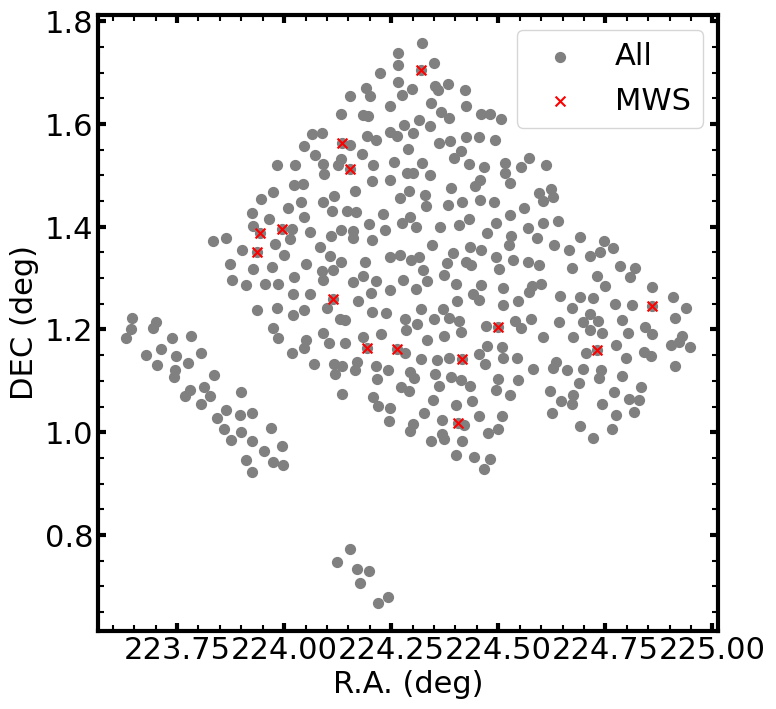

In [39]:
plt.figure(figsize = (8, 8))

plt.scatter(fm['TARGET_RA'], fm['TARGET_DEC'], color = 'grey', s = 50, label = 'All')
plt.scatter(fm['TARGET_RA'][is_mws], fm['TARGET_DEC'][is_mws], color = 'r', s = 50, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

### Healpix based redrock file

In [40]:
# Filename -
z_filename = f'redrock-{survey}-{program}-{hpx}.fits'

In [41]:
h_rr = fits.open(f'{tgt_dir}/{z_filename}')
h_rr.info()
h_rr.close()

Filename: /global/cfs/cdirs/desi/public/dr1/spectro/redux/guadalupe//healpix/main/dark/81/8194/redrock-main-dark-8194.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   ()      
  1  REDSHIFTS     1 BinTableHDU     32   407R x 11C   [K, D, D, K, D, 10D, K, 6A, 20A, K, D]   
  2  FIBERMAP      1 BinTableHDU    143   407R x 67C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  3  EXP_FIBERMAP    1 BinTableHDU     61   770R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  4  TSNR2         1 BinTableHDU     75   407R x 33C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


The redrock* file has 4 extensions:

* **REDSHIFTS** consists of redshift information and outputs from redrock.
* **FIBERMAP** is similar to the one in coadd* file and has information about the targets.
* **EXP_FIBERMAP** is again similar to the one in the coadd* file and has exposure information about the targets.
* **TSNR2** contains information about the expected SNR measurements for the targets.

Information about the datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html). <br/>
You can in principle use these files directly and write your own code to access the spectra. However, `desispec` also provides a function for accessing the coadded spectra as shown below.

<a class="anchor" id="spectra"></a>
## Working with Coadded Spectra using _desispec.io.read_spectra()_

In [42]:
# Using desispec to read the spectra

coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data

INFO:spectra.py:291:read_spectra: iotime 0.271 sec to read coadd-main-dark-8194.fits at 2024-01-09T14:20:32.851312


In [43]:
# Selecting the particular spectra of the targetid

row = (coadd_tgts == targetid)
coadd_spec = coadd_obj[row]

In [44]:
coadd_spec.wave

{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}

In [45]:
coadd_spec.flux

{'b': array([[4.82403755, 3.32900167, 0.56968939, ..., 2.56049824, 2.56779766,
         2.50022316]]),
 'r': array([[-1.52820539, -0.69116563,  3.25720406, ..., -0.93266469,
          1.9738977 ,  3.31601119]]),
 'z': array([[3.28516293, 2.83025861, 2.56330395, ..., 2.61270261, 2.49429703,
         1.95832014]])}

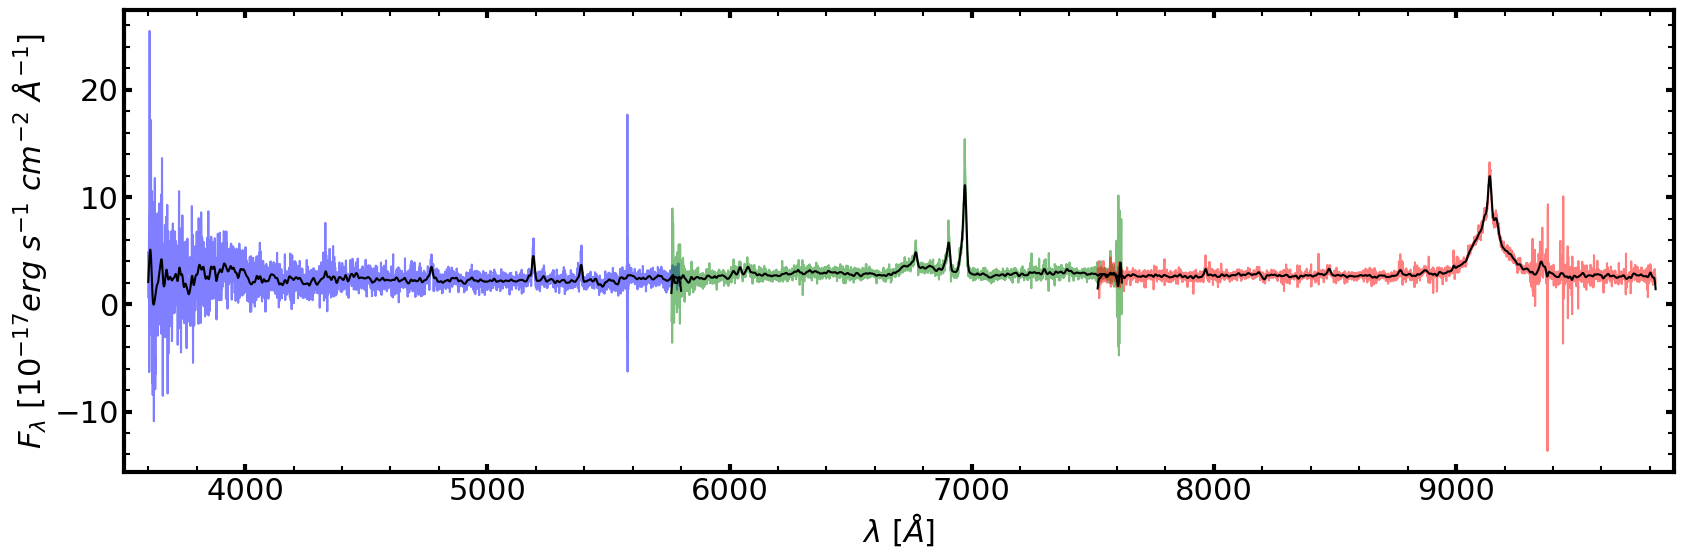

In [46]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(coadd_spec.wave['b'], coadd_spec.flux['b'][0], color = 'b', alpha = 0.5)
plt.plot(coadd_spec.wave['r'], coadd_spec.flux['r'][0], color = 'g', alpha = 0.5)
plt.plot(coadd_spec.wave['z'], coadd_spec.flux['z'][0], color = 'r', alpha = 0.5)
# Over-plotting smoothed spectra in black for all the three arms
plt.plot(coadd_spec.wave['b'], convolve(coadd_spec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['r'], convolve(coadd_spec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['z'], convolve(coadd_spec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
plt.xlim([3500, 9900])
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

The coadded spectra available is divided based on the observed (B,R,Z) camera. We can obtain the joint spectrum using the available `coaddition.coadd_cameras` function.

In [47]:
# Combined Spectra - 

spec_combined = coaddition.coadd_cameras(coadd_spec)

In [48]:
spec_combined.wave

{'brz': array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])}

In [49]:
spec_combined.flux

{'brz': array([[4.82403755, 3.32900167, 0.56968939, ..., 2.61270261, 2.49429703,
         1.95832014]])}

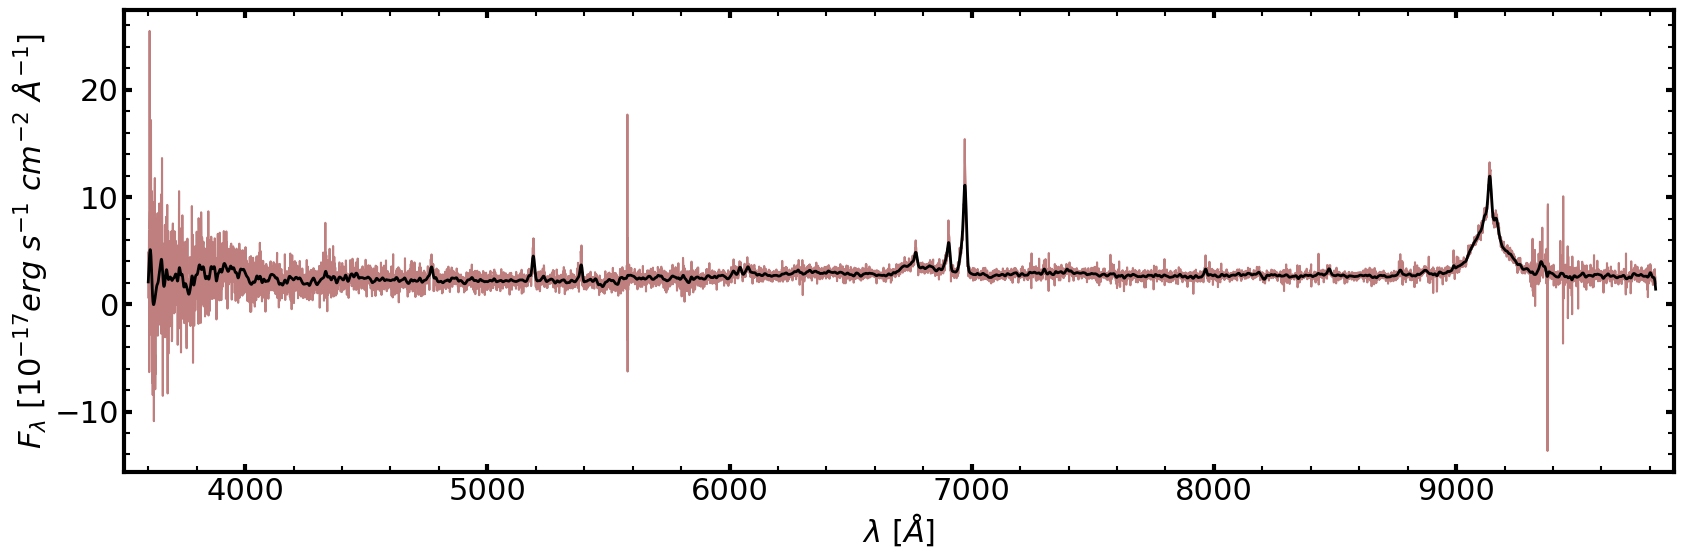

In [50]:
# Plotting this combined spectra - 

# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the combined spectrum in maroon
plt.plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0], color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectra 
plt.plot(spec_combined.wave['brz'], convolve(spec_combined.flux['brz'][0], Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlim([3500, 9900])
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot all the available spectra available for this object

INFO:spectra.py:291:read_spectra: iotime 0.306 sec to read coadd-main-bright-8194.fits at 2024-01-09T14:20:33.905191
INFO:spectra.py:291:read_spectra: iotime 0.262 sec to read coadd-main-dark-8194.fits at 2024-01-09T14:20:34.432209


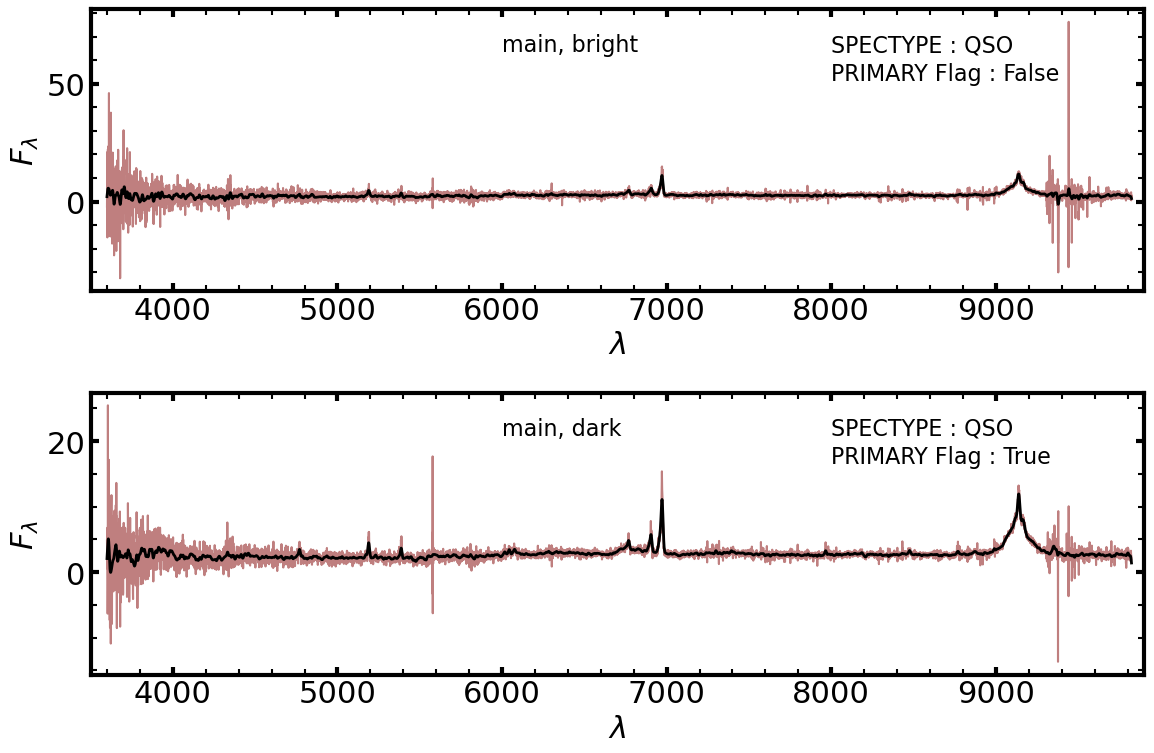

In [51]:
# Number of spectra 
n = len(zcat_sel)

fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = survey_col[jj]
    program = program_col[jj]
    hpx = hpx_col[jj]
    
    spectype = zcat_sel['SPECTYPE'].astype(str).data[jj]
    primary_flag = zcat_sel['ZCAT_PRIMARY'].data[jj]

    tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'
    coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'
    coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
    coadd_tgts = coadd_obj.target_ids().data
    row = (coadd_tgts == targetid)
    coadd_spec = coadd_obj[row]

    spec_combined = coaddition.coadd_cameras(coadd_spec)
    
    # Plot the combined spectrum in maroon
    ax[jj].plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0], color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    ax[jj].plot(spec_combined.wave['brz'], convolve(spec_combined.flux['brz'][0], Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = '$\lambda$', ylabel = '$F_{\lambda}$')
    
    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)
    
plt.tight_layout()

Redrock uses a set of templates to classify sources and find their redshifts. You can use the zbest fit coefficients with the redrock-templates to compare the spectra to the best-fit template. A tutorial on how to do this is available [here](https://github.com/desihub/tutorials/blob/main/redrock/RedrockOutputs.ipynb).

<a class="anchor" id="ref"></a>
# References

* DESI experiment paper: https://arxiv.org/abs/1611.00036
* Information about DR1: https://data.desi.lbl.gov/public/dr1
* Information about EDR: https://data.desi.lbl.gov/public/edr
* Targetting Information: 
    * [SV1, SV2, SV3](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) (Section 2.3.)
    * [main](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) survey
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* Redrock Template Tutorial: https://github.com/desihub/tutorials/blob/main/redrock/RedrockOutputs.ipynb

<a class="anchor" id="ref"></a>
### Internal References 
##### (**link exclusive to DESI collaborators**)

* Information about Survey Validation: https://desi.lbl.gov/trac/wiki/SurveyValidation

* Targetting Information: 
    * [SV1](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation) 
    * [SV2](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV2)
    * [SV3](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV3) 